# 파이토치 MNIST 모델

## modules import 

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.datasets
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

## 전처리 설정
- `transform.Compose`

In [2]:
transform = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize((0.5, ), (0.5, ))])

## 데이터 로드 및 데이터 확인

In [3]:
trainset = torchvision.datasets.MNIST(root = '',
                                     train = True,
                                     download = True,
                                     transform = transform)

testset = torchvision.datasets.MNIST(root = '',
                                     train = False,
                                     download = True,
                                     transform = transform)

In [5]:
train_loader = DataLoader(trainset,
                         batch_size = 128,
                         shuffle = True,
                         num_workers = 2)

test_loader = DataLoader(testset,
                        batch_size = 128,
                        shuffle = False,
                        num_workers = 2)

In [6]:
image, label = next(iter(train_loader))

In [7]:
image.shape, label.shape

# 128 : Batch_size
# 1 : RGB (gray_scale)
# 28, 28 : Image Size

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

In [8]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    fig = plt.figure(figsize = (10, 5))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

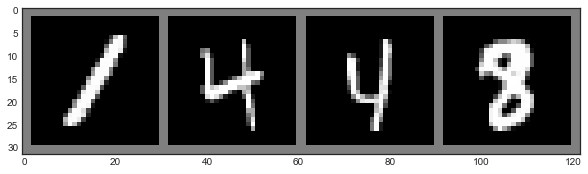

In [10]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images[:4]))

## 신경망 구성

In [13]:
class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        
        # 신경망구조(아키텍처) 정의
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        ## 최종 output은 10
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        # Pooling 두번 거치기
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        # Flatten으로 모양바꿔주기
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        
        return num_features
    
net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


- `.parameters()` 

In [14]:
params = list(net.parameters())
print(len(params))
print(params[0].size())

10
torch.Size([6, 1, 3, 3])


임의의 값을 넣어 forward값 확인

In [15]:
input = torch.randn(1,1, 28, 28)
out = net(input)
print(out)

tensor([[ 0.0473, -0.0055,  0.0644,  0.0894, -0.0903,  0.0756,  0.0812,  0.0202,
          0.0237, -0.1663]], grad_fn=<AddmmBackward0>)


## 손실함수와 옵티마이저

In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr = 0.001, momentum = 0.9)

## 모델 학습

- `optimizer.zero_grad` : 가중치의 그래디언트 초기화

- loss 계산

- `loss.backward()`

- `optmizer.step()` : 업데이트

- 배치수 확인

In [17]:
total_batch = len(train_loader)
print(total_batch)

469


- 설명을 위해 `epochs=2`로 지정

In [19]:
for epoch in range(2):
    
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        
        optimizer.zero_grad()
        
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        if i % 100 == 99:
            print('Epoch: {}, Iter: {}, Loss: {}'.format(epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0

Epoch: 1, Iter: 100, Loss: 2.284232244491577
Epoch: 1, Iter: 200, Loss: 2.268396441936493
Epoch: 1, Iter: 300, Loss: 2.2407712292671205
Epoch: 1, Iter: 400, Loss: 2.1737748312950136
Epoch: 2, Iter: 100, Loss: 1.6765574073791505
Epoch: 2, Iter: 200, Loss: 1.009032227396965
Epoch: 2, Iter: 300, Loss: 0.7072046357393265
Epoch: 2, Iter: 400, Loss: 0.5746664389967918


## 모델의 저장 및 로드

- `torch.save`
  - `net.state_dict()`를 저장

- `torch.load`
  - `load_state_dict`로 모델을 로드

In [20]:
PATH = './mnist_net.pth'
torch.save(net.state_dict(), PATH)

In [21]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [22]:
net.parameters

<bound method Module.parameters of Net(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)>

## 모델 테스트

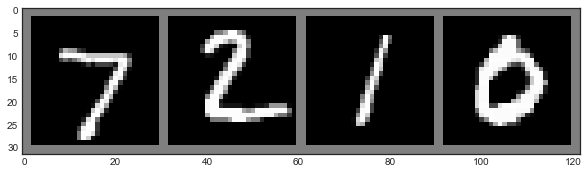

In [23]:
dataiter = iter(test_loader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images[:4]))

In [24]:
outputs = net(images)

In [25]:
_, predicted = torch.max(outputs, 1)
print(predicted)

tensor([7, 2, 1, 0, 4, 1, 4, 9, 6, 9, 0, 8, 9, 0, 1, 5, 9, 7, 3, 4, 7, 6, 6, 5,
        4, 0, 7, 4, 0, 1, 3, 1, 3, 6, 7, 2, 7, 1, 2, 1, 1, 7, 4, 2, 3, 5, 3, 2,
        4, 4, 6, 3, 5, 5, 6, 5, 4, 1, 9, 5, 7, 8, 4, 3, 7, 4, 2, 4, 3, 0, 7, 0,
        2, 8, 1, 7, 3, 7, 9, 7, 7, 6, 2, 7, 8, 4, 7, 5, 6, 1, 3, 6, 4, 3, 1, 4,
        1, 7, 6, 9, 6, 0, 5, 4, 9, 4, 2, 1, 9, 4, 3, 1, 3, 9, 9, 4, 4, 4, 4, 8,
        5, 4, 7, 6, 9, 9, 0, 5])


In [27]:
print(''.join('{}\t'.format(str(predicted[j].numpy())) for j in range(4)))

7	2	1	0	


In [28]:
correct = 0
total = 0

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        
print(100 * correct / total)

86.17


## GPU 설정 후 학습
- 설정 후, 모델과 데이터에 `to`로 GPU를 사용 가능한 형태로 변환 해줘야 한다.

- `.cuda()` 로도 가능

- 현재 GPU 설정

In [29]:
torch.cuda.is_available()

True

In [30]:
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else "cpu")

In [31]:
device

device(type='cuda')

- 데이터 로드


In [44]:
transform = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize((0.5, ), (0.5, ))])

trainset = torchvision.datasets.MNIST(root = '',
                                     train = True,
                                     download = True,
                                     transform = transform)

testset = torchvision.datasets.MNIST(root = '',
                                     train = False,
                                     download = True,
                                     transform = transform)

train_loader = DataLoader(trainset,
                         batch_size = 128,
                         shuffle = True,
                         num_workers = 2)

test_loader = DataLoader(testset,
                        batch_size = 128,
                        shuffle = False,
                        num_workers = 2)

- 모델 생성

In [45]:
class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        
        # 신경망구조(아키텍처) 정의
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        ## 최종 output은 10
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        # Pooling 두번 거치기
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        # Flatten으로 모양바꿔주기
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        
        return num_features
    
net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [46]:
# 만든모델을 cuda(gpu)로 보내기
net = Net().to(device)

In [47]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr = 0.001, momentum = 0.9)

In [48]:
for epoch in range(10):
    
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        
        optimizer.zero_grad()
        
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        if i % 100 == 99:
            print('Epoch: {}, Iter: {}, Loss: {}'.format(epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0

Epoch: 1, Iter: 100, Loss: 2.2988278126716613
Epoch: 1, Iter: 200, Loss: 2.286623167991638
Epoch: 1, Iter: 300, Loss: 2.269572925567627
Epoch: 1, Iter: 400, Loss: 2.2338986825942992
Epoch: 2, Iter: 100, Loss: 2.0165594565868377
Epoch: 2, Iter: 200, Loss: 1.5438083732128143
Epoch: 2, Iter: 300, Loss: 0.9885885012149811
Epoch: 2, Iter: 400, Loss: 0.7045341050624847
Epoch: 3, Iter: 100, Loss: 0.522680375277996
Epoch: 3, Iter: 200, Loss: 0.4560423120856285
Epoch: 3, Iter: 300, Loss: 0.4288595649600029
Epoch: 3, Iter: 400, Loss: 0.3808559240400791
Epoch: 4, Iter: 100, Loss: 0.3543462686240673
Epoch: 4, Iter: 200, Loss: 0.3274016021192074
Epoch: 4, Iter: 300, Loss: 0.2966358356177807
Epoch: 4, Iter: 400, Loss: 0.29431433483958247
Epoch: 5, Iter: 100, Loss: 0.2671714493632317
Epoch: 5, Iter: 200, Loss: 0.24713702209293842
Epoch: 5, Iter: 300, Loss: 0.2436513452231884
Epoch: 5, Iter: 400, Loss: 0.22823494471609593
Epoch: 6, Iter: 100, Loss: 0.21019356690347193
Epoch: 6, Iter: 200, Loss: 0.1973

In [49]:
correct = 0
total = 0

with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        
print(100 * correct / total)

96.7
